# <center> Decision Tree </center>

Decison Tree hierarchical stuctures used for top-down partitioning of the Feature space. Decision Tree can be used for solving both Classification and Regression problems. The space is divided by a series of Decision Functions arranged serially in a hierarchical order. The objective of the division is to reduce the overall **impurity** of the data. Thereby, gradually moving towards pure data.

## Understanding Node Impurity 

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sns.set()

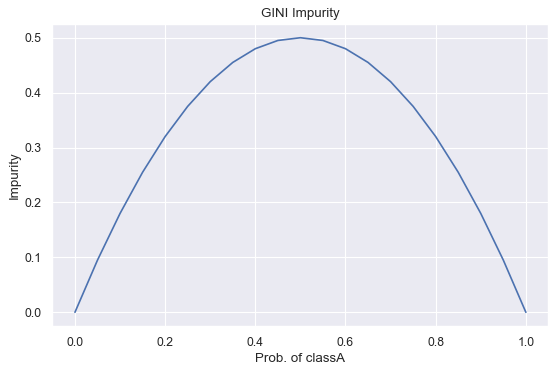

In [2]:
total = 200
classA = 0
imp_list1 = []
prob_list = []
while classA <= total:
    classB = total - classA
    label_probA = classA/total
    label_probB = classB/total
    
    imp = 1 - (label_probA**2+label_probB**2)  ### GINI Impurity
    imp_list1.append(imp)
    prob_list.append(label_probA)
    classA += 10

plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list1)
plt.title("GINI Impurity")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.show()

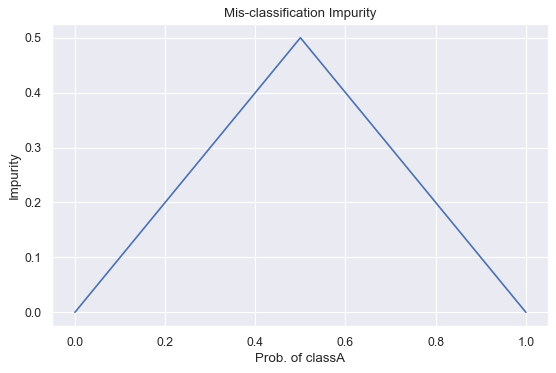

In [3]:
total = 200
classA = 0
imp_list2 = []
prob_list = []
while classA <= total:
    classB = total - classA
    label_probA = classA/total
    label_probB = classB/total
    
    imp = 1 - max(label_probA,label_probB)  ## Mis-Classification Impurity
    imp_list2.append(imp)
    prob_list.append(label_probA)
    classA += 10

plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list2)
plt.title("Mis-classification Impurity")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.show()

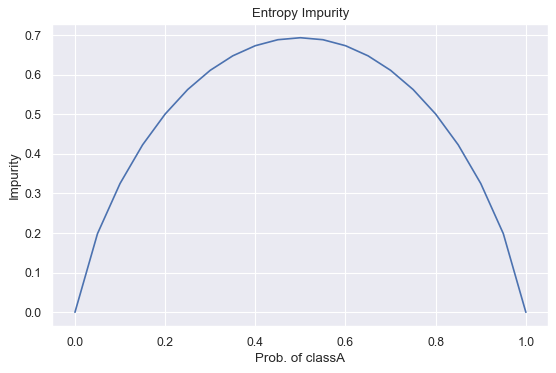

In [4]:
total = 200
classA = 0
imp_list3 = []
prob_list = []
while classA <= total:
    classB = total - classA
    label_probA = classA/total
    label_probB = classB/total
    if label_probA == 0 or label_probB == 0:  
        imp = 0                                              ## Entropy Impurity
    else:
        imp = -1*(label_probA*np.log(label_probA) + label_probB*np.log(label_probB))
    imp_list3.append(imp)
    prob_list.append(label_probA)
    classA += 10

plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list3)
plt.title("Entropy Impurity")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.show()

### Plotting it together

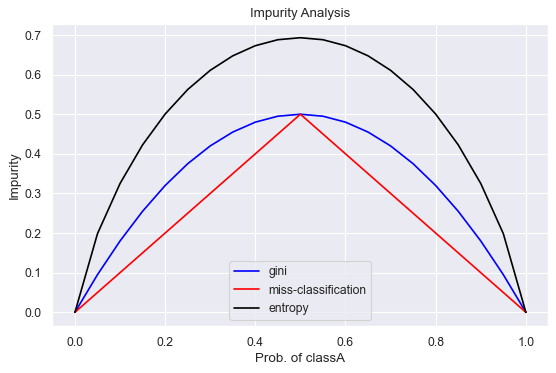

In [5]:
plt.figure(figsize=(8,5),dpi=80)
plt.plot(prob_list,imp_list1,c='blue',label='gini')
plt.plot(prob_list,imp_list2,c='red',label='miss-classification')
plt.plot(prob_list,imp_list3,c='black',label='entropy')
plt.title("Impurity Analysis")
plt.xlabel("Prob. of classA")
plt.ylabel("Impurity")
plt.legend()
plt.show()

---

# Two-Means Decision Tree (TMDT)

In [6]:
class C_Node:
    def __init__(self):
        self.m_NodeIndx = -1
        self.m_Impurity = -1
        self.m_NodeDepth = -1
        self.m_ParentNodeIndx = -1
        self.m_LeftChildIndx = -1
        self.m_RightChildIndx = -1
        self.m_Centroids=None
        self.m_IsDecisionNode = None
        self.m_DataLength= None
        self.m_Label = None
        
    def setNode(self,nodeIndx,nodeDepth,parentNodeIndx):  
        self.m_NodeIndx = nodeIndx
        self.m_NodeDepth = nodeDepth
        self.m_ParentNodeIndx = parentNodeIndx

In [7]:
class C_Tree:
 
    def __init__(self,maxDepth,maxNodeNum,path,dataNumThresh,impThresh,impDropThresh,impType):
        
        self.m_MaxDepth = maxDepth
        self.m_MaxNodeNum = maxNodeNum
        self.m_CurrNodeNum = 0                       # Counter for Nodes in tree while building
        self.m_NodeArray = [C_Node() for i in range(self.m_MaxNodeNum)]
        self.m_Path = path
        self.m_DataNumThresh = dataNumThresh
        self.m_ImpThresh = impThresh
        self.m_ImpDropThresh = impDropThresh
        self.m_ImpType = impType

    def getImpurity(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        if (len(datalist.shape) == 1):
            return 0
        else:
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            label_prob = label_count/np.sum(label_count,dtype=np.float64)

            if self.m_ImpType == 'misclassification':                         ##Mis-classification Impurity
                if len(label_prob) == 1:
                    imp = 0
                else:
                    imp = 1 - max(label_prob)

            if self.m_ImpType == 'gini':                                        ##Gini Impurity
                imp = 1 - (np.sum(label_prob**2)) 

            if self.m_ImpType == 'entropy':                                     ##Entropy Impurity
                imp = -1 * np.sum(np.array([p*np.log(p) for p in label_prob]))
            return(imp)
        
    def infoGain(self,data_left,data_right,curr_imp):    ## Gives the change in Impurity from parent to children
        filename1 = "LeftFile.csv"
        filename2 = "RightFile.csv"
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        imp_left = self.getImpurity(filename1)
        imp_right = self.getImpurity(filename2)
        l = len(data_left)
        r = len(data_right)
        totalImp = (l*imp_left + r*imp_right)/(l+r)
        return (curr_imp - totalImp)      
        
    def splitDataFile(self,node_obj,data_left,data_right):  
        filename1=self.m_Path+"/"+"d_"+str(node_obj.m_LeftChildIndx)+".csv"
        filename2=self.m_Path+"/"+"d_"+str(node_obj.m_RightChildIndx)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")

    def twoMeans(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        X = datalist[:,:datalist.shape[1]-1]
        y = np.array([int(i) for i in datalist[:,-1]])
        label, label_count = np.unique(y, return_counts=True)

        kmeans = KMeans(n_clusters=2).fit(X)
        centroids = kmeans.cluster_centers_
        cluster_labels = kmeans.labels_

        data_left=[]
        data_right=[]
        label, label_count = np.unique(cluster_labels, return_counts=True)
        for i in range(len(X)):
            if cluster_labels[i]==label[0]:
                data_left.append(datalist[i])
            if cluster_labels[i]==label[1]:
                data_right.append(datalist[i])     
        data_left=np.array(data_left)
        data_right=np.array(data_right)
        return data_left,data_right,centroids

    def checkTerminationCondition(self,node,filename):
        datalist = np.genfromtxt(filename, delimiter=',')
        if len(datalist.shape) == 1:
            IsDecisionNode = False
            dataLength = 1
            Label = datalist[-1]
            imp = 0
            return IsDecisionNode,dataLength,Label,0,None,[],[] 
        else:    
            dataLength = datalist.shape[0]    
            x = datalist[:,:datalist.shape[1]-1]
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            data_left,data_right,centroids = self.twoMeans(filename)
            curr_imp = self.getImpurity(filename)
            best_gain = self.infoGain(data_left,data_right,curr_imp) 
            if (dataLength <= self.m_DataNumThresh or curr_imp <= self.m_ImpThresh or
                            best_gain < self.m_ImpDropThresh or node.m_NodeDepth >= self.m_MaxDepth):
                
                IsDecisionNode = False
                Label = label[np.argmax(label_count)]
            
            else: 
                IsDecisionNode = True
                Label = None
                    
            return IsDecisionNode,dataLength,Label,curr_imp,centroids,data_left,data_right
        
    def printNodeData(self,node):
        print(str(node.m_NodeIndx)+"-----node index")
        print(str(node.m_Label)+"-------node Label")
        print(str(node.m_NodeDepth)+"------node Depth")
        print(str(node.m_DataLength)+"----- no. of datapoints")
        print(str(node.m_Impurity)+"-------- Impurity")
        if node.m_Label != None:
            print("This is a Leaf Node!")
        else:
            print("This is a Decision Node!")
        print("-------------------------")
        
    def fit(self,X_train,y_train):
        train_data = np.hstack((X_train,np.matrix(y_train).T))   #### Setting the Root Node 
        fileName = self.m_Path+"/"+"d_0.csv"
        train_data = pd.DataFrame(train_data)
        train_data.to_csv(fileName,index=False,header=False )
        
        self.m_NodeArray[0].setNode(0,0,-1)
        self.m_CurrNodeNum = self.m_CurrNodeNum+1

        for nodeCount in range(self.m_MaxNodeNum): 

            if (self.m_NodeArray[nodeCount].m_NodeIndx == nodeCount and 
                self.m_NodeArray[nodeCount].m_LeftChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_RightChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_NodeDepth >= 0):  

                dataFileName = self.m_Path+"/"+"d_"+str(self.m_NodeArray[nodeCount].m_NodeIndx)+".csv" 

                isDecisionNode,dataLength,label,impurity,centroids,data_left,data_right = self.checkTerminationCondition(self.m_NodeArray[nodeCount],dataFileName)
                
                self.m_NodeArray[nodeCount].m_DataLength = dataLength
                self.m_NodeArray[nodeCount].m_Impurity = impurity
                self.m_NodeArray[nodeCount].m_Label = label
                self.m_NodeArray[nodeCount].m_Centroids = centroids
                if isDecisionNode == False:
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = False
                    
                if isDecisionNode == True:
                    lci = self.m_CurrNodeNum
                    rci = self.m_CurrNodeNum+1
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = True
                    self.m_NodeArray[nodeCount].m_LeftChildIndx = lci
                    self.m_NodeArray[nodeCount].m_RightChildIndx = rci
                    
                    self.m_NodeArray[lci].setNode(lci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                            self.m_NodeArray[nodeCount].m_NodeIndx)

                    self.m_NodeArray[rci].setNode(rci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                            self.m_NodeArray[nodeCount].m_NodeIndx)

                    self.splitDataFile(self.m_NodeArray[nodeCount],data_left,data_right)

                    self.m_CurrNodeNum = self.m_CurrNodeNum+2
                    
                self.printNodeData(self.m_NodeArray[nodeCount])
            else:
                print("Tree Model Trained!!!!!!!!")
                break  

    def decisionRule(self,x,node):
        mean1 = node.m_Centroids[0]
        mean2 = node.m_Centroids[1]
        dist1 = np.linalg.norm(x-mean1)
        dist2 = np.linalg.norm(x-mean2)

        if dist1 <= dist2:
            return 0
        else:
            return 1
        
    def predict(self,X_test):
        pred = np.zeros((X_test.shape[0],1))
        for i in range(X_test.shape[0]):
            nodeCount=0
            x = X_test[i]
            while(nodeCount < self.m_MaxNodeNum and self.m_NodeArray[nodeCount].m_IsDecisionNode == True):

                if self.decisionRule(x,self.m_NodeArray[nodeCount])== 0:
                    nodeCount = self.m_NodeArray[nodeCount].m_LeftChildIndx
                else:
                    nodeCount = self.m_NodeArray[nodeCount].m_RightChildIndx

            y_pred = self.m_NodeArray[nodeCount].m_Label
            pred[i][0] = y_pred
        return(pred)

In [8]:
from sklearn.datasets import load_wine
dataset = load_wine()
X = dataset.data
y = dataset.target
print(X.shape,y.shape)

(178, 13) (178,)


In [21]:
maxDepth = 4
maxNodeNum = 2**(maxDepth+1)-1
dataNumThresh = 8
impThresh  = 0.01
impDropThresh = 1e-4
impType = 'gini'
path = "./node_files"
#########################################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

CTree = C_Tree(maxDepth,maxNodeNum,path,dataNumThresh,impThresh,impDropThresh,impType)

CTree.fit(X_train,y_train)

y_pred = CTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, normalize=True)
print("Accuracy Two Means Decision Tree: {}".format(accuracy))
print("*******************************************")

j =  12
theta =  760.0
0-----node index
None-------node Label
0------node Depth
142----- no. of datapoints
0.6622693909938504-------- Impurity
This is a Decision Node!
-------------------------
j =  11
theta =  2.51
1-----node index
None-------node Label
1------node Depth
54----- no. of datapoints
0.23388203017832643-------- Impurity
This is a Decision Node!
-------------------------
j =  6
theta =  1.25
2-----node index
None-------node Label
1------node Depth
88----- no. of datapoints
0.509297520661157-------- Impurity
This is a Decision Node!
-------------------------
j =  9
theta =  3.52
3-----node index
None-------node Label
2------node Depth
49----- no. of datapoints
0.07830070803831746-------- Impurity
This is a Decision Node!
-------------------------
4-----node index
2-------node Label
2------node Depth
5----- no. of datapoints
0.31999999999999984-------- Impurity
This is a Leaf Node!
-------------------------
j =  11
theta =  1.59
5-----node index
None-------node Label
2------

In [10]:
def impDropAlongDepth(dtree):
    maxNodeNum = dtree.m_MaxNodeNum
    maxDepth = dtree.m_MaxDepth
    imp_depth = []
    for depth in range(maxDepth+1):
        nodeCount = 0
        impurity_ls = []
        dataNum_ls = []
        while nodeCount < maxNodeNum:
            if dtree.m_NodeArray[nodeCount].m_NodeDepth == depth:
                impurity_ls.append(dtree.m_NodeArray[nodeCount].m_Impurity)
                dataNum_ls.append(dtree.m_NodeArray[nodeCount].m_DataLength)
            nodeCount += 1
        if len(impurity_ls) != 0:
            impurity_ls = impurity_ls/np.sum(impurity_ls)
            dataNum_ls = dataNum_ls/np.sum(dataNum_ls)
        imp_depth.append(np.sum(np.multiply(impurity_ls,dataNum_ls)))
    return imp_depth            

In [11]:
def impDropPlotAlongDepth(imp_depth):
    plt.figure(figsize=(8,6))
    plt.plot(imp_depth)
    plt.title("Impurity Drop Along Tree Depth")
    plt.xlabel("Depth of Tree")
    plt.ylabel("Weighted Impurity")
    plt.show()

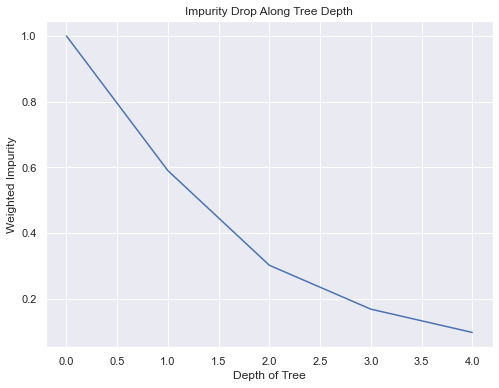

In [12]:
imp_depth = impDropAlongDepth(CTree)
impDropPlotAlongDepth(imp_depth)

## C4.5 Decision Tree

In [13]:
class C_Node:
    def __init__(self):
        self.m_NodeIndx = -1
        self.m_Impurity = -1
        self.m_NodeDepth = -1
        self.m_ParentNodeIndx = -1
        self.m_LeftChildIndx = -1
        self.m_RightChildIndx = -1
        self.m_DataLength = None
        self.m_IsDecisionNode = None
        self.m_Params = None
        self.m_Label = -1
        
    def setNode(self,nodeIndx,nodeDepth,parentNodeIndx):  
        self.m_NodeIndx = nodeIndx
        self.m_NodeDepth = nodeDepth
        self.m_ParentNodeIndx = parentNodeIndx 

class C_Tree:
 
    def __init__(self,maxDepth,maxNodeNum,path,dataNumThresh,impThresh,ImpDropThresh,impType):
        
        self.m_MaxDepth = maxDepth
        self.m_MaxNodeNum = maxNodeNum
        self.m_CurrNodeNum = 0 
        self.m_NodeArray = [C_Node() for i in range(self.m_MaxNodeNum)]
        self.m_Path = path
        self.m_DataNumThresh = dataNumThresh
        self.m_ImpThresh = impThresh
        self.m_ImpDropThresh = ImpDropThresh
        self.m_ImpType = impType

    def getImpurity(self,dataFileName):
        datalist = np.genfromtxt(dataFileName, delimiter=',')
        if (len(datalist.shape) == 1):
            return 0
        else:
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            label_prob = label_count/np.sum(label_count,dtype=np.float64)

            if self.m_ImpType == 'misclassification':                         ##Mis-classification Impurity
                if len(label_prob) == 1:
                    imp = 0
                else:
                    imp = 1 - max(label_prob)

            if self.m_ImpType == 'gini':                                        ##Gini Impurity
                imp = 1 - (np.sum(label_prob**2)) 

            if self.m_ImpType == 'entropy':                                     ##Entropy Impurity
                imp = -1 * np.sum(np.array([p*np.log(p) for p in label_prob]))
            return(imp)
        
    def infoGain(self,data_left,data_right,curr_imp):    
        filename1 = "LeftFile.csv"
        filename2 = "RightFile.csv"
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        imp_left = self.getImpurity(filename1)
        imp_right = self.getImpurity(filename2)
        l = len(data_left)
        r = len(data_right)
        totalImp = (l*imp_left + r*imp_right)/(l+r)
        return (curr_imp - totalImp)      
        
    def splitDataFile(self,node,filename,params):
        rows = np.genfromtxt(filename,delimiter=',')
        data_left,data_right = self.partition(rows,params)
        filename1 = self.m_Path+"/"+"d_"+str(node.m_LeftChildIndx)+".csv"
        filename2 = self.m_Path+"/"+"d_"+str(node.m_RightChildIndx)+".csv"
        os.makedirs(os.path.dirname(filename1), exist_ok=True)
        os.makedirs(os.path.dirname(filename2), exist_ok=True)
        np.savetxt(filename1, data_left, delimiter = ",")
        np.savetxt(filename2, data_right, delimiter = ",")
        
    class Params:

        def __init__(self, dim, theta):
            self.dim = dim
            self.theta = theta

        def match(self, example):
            # Compare the feature value in an example to the
            # feature value in this question.
            val = example[self.dim]
            return val >= self.theta
    
    def partition(self,rows, params):
        true_rows, false_rows = [], []
        for row in rows:
            if params.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_split(self,filename):
        """Find the best question to ask by iterating over every feature / value
        and calculating the information gain."""
        best_gain = 0  # keep track of the best information gain
        best_params = None  # keep train of the feature / value that produced it
        current_uncertainty = self.getImpurity(filename)
        rows = np.genfromtxt(filename,delimiter=',')
        n_features = len(rows[0]) - 1  # number of columns

        for col in range(n_features):  # for each feature

            values = set([row[col] for row in rows])  # unique values in the column

            for val in values:  # for each value

                question = self.Params(col, val)

                # try splitting the dataset
                true_rows, false_rows = self.partition(rows, question)

                # Skip this split if it doesn't divide the
                # dataset.
                if len(true_rows) == 0 or len(false_rows) == 0:
                    continue

                # Calculate the information gain from this split
                gain = self.infoGain(true_rows, false_rows, current_uncertainty)

                # You actually can use '>' instead of '>=' here
                # but I wanted the tree to look a certain way for our
                # toy dataset.
                if gain >= best_gain:
                    best_gain, best_params = gain, question

        return best_gain, best_params, current_uncertainty
    
    def checkTerminationCondition(self,node,filename):
        datalist = np.genfromtxt(filename, delimiter=',')
        if len(datalist.shape) == 1:
            IsDecisionNode = False
            dataLength = 1
            Label = datalist[-1]
            imp = 0
            return IsDecisionNode,dataLength,Label,0,None 
        else:    
            dataLength = datalist.shape[0]    
            x = datalist[:,:datalist.shape[1]-1]
            y = np.array([int(i) for i in datalist[:,-1]])
            label, label_count = np.unique(y, return_counts=True)
            best_gain,best_params,imp = self.find_best_split(filename)
            
            if (dataLength <= self.m_DataNumThresh or imp <= self.m_ImpThresh or
                            best_gain < self.m_ImpDropThresh or node.m_NodeDepth >= self.m_MaxDepth):
                
                IsDecisionNode = False
                Label = label[np.argmax(label_count)]
            
            else: 
                IsDecisionNode = True
                Label = None
                    
            return IsDecisionNode,dataLength,Label,imp,best_params
        
    def printNodeData(self,node):
        print(str(node.m_NodeIndx)+"-----node index")
        print(str(node.m_Label)+"-------node Label")
        print(str(node.m_NodeDepth)+"------node Depth")
        print(str(node.m_DataLength)+"----- no. of datapoints")
        print(str(node.m_Impurity)+"-------- Impurity")
        if node.m_Label != None:
            print("This is a Leaf Node!")
        else:
            print("This is a Decision Node!")
        print("-------------------------")
        
    def fit(self,X_train,y_train):
        train_data = np.hstack((X_train,np.matrix(y_train).T))
        fileName = self.m_Path+"/"+"d_0.csv"
        train_data = pd.DataFrame(train_data)
        train_data.to_csv(fileName,index=False,header=False )
        
        self.m_NodeArray[0].setNode(0,0,-1)
        self.m_CurrNodeNum = self.m_CurrNodeNum+1

        for nodeCount in range(self.m_MaxNodeNum): 

            if (self.m_NodeArray[nodeCount].m_NodeIndx == nodeCount and 
                self.m_NodeArray[nodeCount].m_LeftChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_RightChildIndx == -1 and 
                self.m_NodeArray[nodeCount].m_NodeDepth >= 0):  

                dataFileName = self.m_Path+"/"+"d_"+str(self.m_NodeArray[nodeCount].m_NodeIndx)+".csv" 

                isDecisionNode,dataLength,label,impurity,params = self.checkTerminationCondition(self.m_NodeArray[nodeCount],dataFileName)
                
                self.m_NodeArray[nodeCount].m_DataLength = dataLength
                self.m_NodeArray[nodeCount].m_Impurity = impurity
                self.m_NodeArray[nodeCount].m_Label = label
                self.m_NodeArray[nodeCount].m_Params = params
                if isDecisionNode == False:
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = False
                    
                    
                if isDecisionNode == True:
                    print("j = ",params.dim)
                    print("theta = ",params.theta)
                    lci = self.m_CurrNodeNum
                    rci = self.m_CurrNodeNum+1
                    self.m_NodeArray[nodeCount].m_IsDecisionNode = True
                    self.m_NodeArray[nodeCount].m_LeftChildIndx = lci
                    self.m_NodeArray[nodeCount].m_RightChildIndx = rci
                    
                    self.m_NodeArray[lci].setNode(lci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                            self.m_NodeArray[nodeCount].m_NodeIndx)

                    self.m_NodeArray[rci].setNode(rci,self.m_NodeArray[nodeCount].m_NodeDepth+1,
                            self.m_NodeArray[nodeCount].m_NodeIndx)

                    self.splitDataFile(self.m_NodeArray[nodeCount],dataFileName,params)

                    self.m_CurrNodeNum = self.m_CurrNodeNum+2
                    
                self.printNodeData(self.m_NodeArray[nodeCount])
            else:
                print("Tree Model Trained!!!!!!!!")
                break  

    def predict(self,X_test):
        pred = np.empty((X_test.shape[0],1))
        for i in range(X_test.shape[0]):
            nodeCount = 0
            x = X_test[i]
            while(nodeCount < self.m_MaxNodeNum and self.m_NodeArray[nodeCount].m_IsDecisionNode == True):
                
                params = self.m_NodeArray[nodeCount].m_Params
                if params != None:
                    if params.match(x) == True:
                        nodeCount = self.m_NodeArray[nodeCount].m_LeftChildIndx
                    else:
                        nodeCount = self.m_NodeArray[nodeCount].m_RightChildIndx
                else:
                    break
            pred[i][0] = int(self.m_NodeArray[nodeCount].m_Label)
        return(pred)

In [14]:
from sklearn.datasets import load_wine
dataset = load_wine()
X = dataset.data
y = dataset.target
print(X.shape,y.shape)

(178, 13) (178,)


In [15]:
maxDepth = 4
maxNodeNum = 2**(maxDepth+1)-1
dataNumThresh = 3
impThresh  = 0.001
impDropThresh = 1e-4
impType = 'gini'
path = './node_files'
#########################################################################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

CTree = C_Tree(maxDepth,maxNodeNum,path,dataNumThresh,impThresh,impDropThresh,impType)

CTree.fit(X_train,y_train)

y_pred = CTree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred, normalize=True)
print("Accuracy my C4.5 Tree",accuracy)
print("*******************************************")

j =  12
theta =  760.0
0-----node index
None-------node Label
0------node Depth
142----- no. of datapoints
0.6567149375123984-------- Impurity
This is a Decision Node!
-------------------------
j =  11
theta =  2.51
1-----node index
None-------node Label
1------node Depth
54----- no. of datapoints
0.2606310013717421-------- Impurity
This is a Decision Node!
-------------------------
j =  11
theta =  2.06
2-----node index
None-------node Label
1------node Depth
88----- no. of datapoints
0.48476239669421484-------- Impurity
This is a Decision Node!
-------------------------
j =  9
theta =  3.52
3-----node index
None-------node Label
2------node Depth
48----- no. of datapoints
0.07986111111111094-------- Impurity
This is a Decision Node!
-------------------------
4-----node index
2-------node Label
2------node Depth
6----- no. of datapoints
0.0-------- Impurity
This is a Leaf Node!
-------------------------
j =  6
theta =  1.25
5-----node index
None-------node Label
2------node Depth
55--

In [16]:
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test,y_pred))

Confusion Matrix:
[[11  0  0]
 [ 0 12  2]
 [ 0  0 11]]


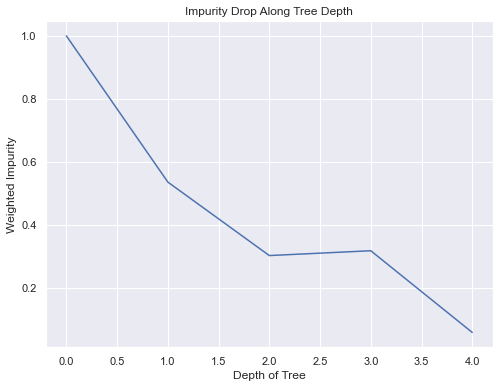

In [17]:
imp_depth = impDropAlongDepth(CTree)
impDropPlotAlongDepth(imp_depth)

---
## Decision Tree Classifier using Sklearn Library

In [19]:
from sklearn.tree import DecisionTreeClassifier

c45 = DecisionTreeClassifier(criterion= "gini", max_depth = CTree.m_MaxDepth,
                                     min_samples_split = CTree.m_DataNumThresh,
                                     min_impurity_decrease = CTree.m_ImpDropThresh,
                                     min_impurity_split = CTree.m_ImpThresh)
c45.fit(X_train,y_train)
y_pred = c45.predict(X_test)
print("Accuracy sklearn C4.5 Tree",c45.score(X_test,y_test))
print("Confusion Matrix")
print(confusion_matrix(y_test,y_pred))

Accuracy sklearn C4.5 Tree 0.8888888888888888
Confusion Matrix
[[11  0  0]
 [ 0 12  2]
 [ 0  2  9]]
/Users/bishal-kumar-shaw/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(
